In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.colors as mcolors
import plotly.express as px
from scipy.stats import gmean

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:

#plt.ion()

In [3]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 4873, 9999]

hypers = {
	'cma':['popsize','seed','sigma'],
	'pso':['popsize', 'w','seed', 'c1', 'c2'],
	'bo-ucb':['seed','kappa'],
	'bo-ei': ['seed','xi'],
	'bo-poi': ['seed','xi']
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
['pso', 'cma', 'bo']


In [4]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

       progname probsize       xtime
0        bt_nas  lrgprob  745.260000
1        bt_nas  medprob   31.943333
2        bt_nas  smlprob    7.383333
3   cfd_rodinia  lrgprob    9.222637
4   cfd_rodinia  medprob    4.186460
5   cfd_rodinia  smlprob    1.578907
6        cg_nas  lrgprob  176.373333
7        cg_nas  medprob    4.796667
8        cg_nas  smlprob    1.143333
9        ft_nas  lrgprob  138.460000
10       ft_nas  medprob    3.903333
11       ft_nas  smlprob    0.940000
12         hpcg  lrgprob   65.220033
13         hpcg  medprob   17.178033
14         hpcg  smlprob    1.949250
15       lulesh  lrgprob   18.396099
16       lulesh  medprob    9.995197
17       lulesh  smlprob    4.854440


In [5]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize', 'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'], dtype='object')
c1 [0.1  0.45 0.8  1.15 1.5   nan]
c2 [0.1  0.45 0.8  1.15 1.5   nan]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['pso' 'cma' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [18.  3. 21.  6. 24.  9. 27. 12. 30. 15. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [   nan  1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778
 30.   ]
w [0.1   0.325 0.55  0.775 1.      nan]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


In [6]:
def drawParetoPlot(*args, **kwargs):
	df = kwargs.pop('data').copy(deep=True)

	method = df['method'].iat[0]
	progname = df['progname'].iat[0]
	probsize = df['probsize'].iat[0]

	cols = hypers[method]
	#print('cols', cols)

	colsToKeep = cols+['globalSample', 'xtime']
	df = df[colsToKeep]

	df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

	#print('dropped cols')
	#print(df.head())

	# need to make one column with the cummax and grab the 300th step
	df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')

	#print('pre new index')
	#print(df.head())

	# rescale the xtime to be baseline-normalized
	df = df.set_index(cols)

	# do the baseline normalization here
	baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
	optimalXtime = baselineXtime/optimalXtime

	df['baselineXtime'] = baselineXtime/df['cummin']

	#print(f'{method} {progname} {probsize}')
	#print(df.head())

	# now make a new df with just the unique values of the hyperparam columns
	# the 'baselineXtime' column will be the max speedup we get after 300 steps
	#toplot = df[df['globalSample'] == 299.0]

	earliestSamples = pd.DataFrame(index=df.index.copy())
	earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
	earliestSamples['firstSample'] = 301
	earliestSamples['maxSpeedup'] = 0

	# now for each index, find the earliest globalSample that is greater than 1.0
	#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
	firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
	maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

	earliestSamples['firstSample'].update(firstSamp)
	earliestSamples['maxSpeedup'].update(maxSpeed)
	#earliestSamples = earliestSamples.reset_index()

	# drop the configurations that never reach the baseline
	#earliestSamples = earliestSamples.dropna(how='any')

	#print('earliestSamples')
	#print(earliestSamples.head())
	#print(earliestSamples.tail())


	#ax = plt.gca()
	
	ax = sns.scatterplot(earliestSamples, x='maxSpeedup', y='firstSample')

	ax.set_xlabel('Max Speedup after 300 steps')
	ax.set_ylabel('Earliest Timestep Surpassing Baseline Execution Time')
	ax.axvline(1.0, label='Baseline Speedup', zorder=0, c='red')
	ax.axvline(optimalXtime, label='Optimal Speedup', zorder=0, c='blue')
	#ax.legend()
	#ax.set_ylim(0, 302)
	ax.set_xlim(0.99, optimalXtime+(0.02*optimalXtime))

	return

def makeParetoPlots(df, progname):
	#print(df.shape)
	#print(df.columns)

	df = df[df['progname'] == progname].reset_index(drop=True)

	#print(df.shape)
	#print(df.columns)

	g = sns.FacetGrid(df, row='method', col='probsize', col_order=probsizes, height=10, aspect=1.5, sharex=False, sharey=False)
	g.map_dataframe(drawParetoPlot, annot=True, xticklabels=True, yticklabels=True)
	
	for ax in g.axes.flatten():
		#ax.tick_params(axis='x', labelbottom=True, labelrotation=90)
		ax.legend(loc='best')
	
	#plt.tight_layout()
	g.set_titles(col_template="Problem Size: {col_name}", row_template="GO Method: {row_name}")
	
	g.fig.subplots_adjust(top=0.96)
	g.fig.suptitle(f'GO Hyperparam Comparison ({progname.upper()})')
	
	plt.show()
	

	return

In [7]:
#makeParetoPlots(overallDF, 'bt_nas')
#makeParetoPlots(overallDF, 'ft_nas')
#makeParetoPlots(overallDF, 'hpcg')
#makeParetoPlots(overallDF, 'lulesh')

In [8]:
# the problem with the makeParetoPlots is that we need to zoom in on the best configurations


In [9]:
# now let's make the same plots in plotly


In [10]:
print(overallDF.columns)
print(overallDF.shape)

gomethods = list(hypers.keys())
print(gomethods)

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize', 'progname', 'seed', 'sigma', 'w', 'xi', 'xtime'], dtype='object')
(20304000, 13)
['cma', 'pso', 'bo-ucb', 'bo-ei', 'bo-poi']


In [11]:
def tupleizeCols(df, cols):
	newColName = f'({",".join([str(col) for col in cols])})'
	df[newColName] = pd.Categorical(list(zip(*[df[col] for col in cols])))
	#df['code'] = df[newColName].cat.codes
	df = df.drop(cols, axis=1)
	return df, newColName

def joinHyperCols(df, cols):
	df = df.copy()
	df['hypers'] = pd.Categorical(list(zip(*[f'{col}='+df[col].astype(str) for col in cols])))
	df = df.drop(cols, axis=1)
	return df 

def fix_fig(fig, labels):
	fig.for_each_xaxis(lambda x: x.update(title = ''))
	fig.add_annotation(x=0.5,y=-0.2,
              text=labels['maxSpeedup'],
               xref="paper", yref="paper")
	fig.for_each_yaxis(lambda y: y.update(title = ''))
	fig.add_annotation(x=-0.05,y=0.5, 
              text=labels['firstSample'], textangle=-90,
               xref="paper", yref="paper")
	fig.show()
	return

In [12]:
probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

def makeOverallPlots(df, baselineXtimes=None, logscale=False, useSeed=None):
	# want each row to be a program, and each column to be a problem size
	# each plot will show the average cumsum across each bo-util fnct, PSO, and CMA

	# if the user supplied a seed
	if not (useSeed is None):
		df = df[df['seed'] == useSeed]
		df = df.drop(['seed'], axis=1)

	otherCols = list(df.columns)
	otherCols.remove('xtime')
	otherCols.remove('globalSample')
	print(otherCols)

	# drop the very first observation
	df = df[df['globalSample'] != 0.0].reset_index()

	# for each category, we need to do a cumulative max
	df['cummax'] = df.groupby(otherCols, dropna=False)['xtime'].transform('cummax')

	def addBaselines(*args, **kwargs):
		data = kwargs['data']
		probsize = data.iloc[0]['probsize']
		progname = data.iloc[0]['progname']
		method = data.iloc[0]['method']

		ax = plt.gca()
		handles, labels = ax.get_legend_handles_labels()

		optimal = globalOptimals[(globalOptimals['progname'] == progname) & (globalOptimals['probsize'] == probsize)]['xtime'].iat[0]
		baseline = globalBaselines[(globalBaselines['progname'] == progname) & (globalBaselines['probsize'] == probsize)]['xtime'].iat[0]

		#avrgCummax = data.groupby(['globalSample'], dropna=False)['cummax'].mean().reset_index()
		# we should be showing geometric means to properly compare the benchmarks
		avrgCummax = data.groupby(['globalSample'], dropna=False)['cummax'].apply(gmean).reset_index()
		csvName = f'{ROOT_DIR}/databases/{MACHINE}-{progname}-{probsize}-{method}-avrgCummax.csv'
		avrgCummax.to_csv(csvName, index=False)
		print('wrote', csvName)
		if baselineXtimes is None:
			step = avrgCummax[avrgCummax['cummax'] > 1.0]['globalSample'].min()
			optimstep = avrgCummax[avrgCummax['cummax'] >= (baseline/optimal)]['globalSample'].min()

			#closestToBaseline = avrgCummax.iloc[avrgCummax['cummax'].idxmax()]['globalSample'].min()
			#closestToOptimal = avrgCummax.iloc[avrgCummax['cummax'].idxmax()]['globalSample'].min()
			if step is None:
				print(f'{progname} {probsize} {method} did not reach baseline')
			else:
				print(f'{progname} {probsize} {method} passed baseline on step {step}')

			if optimstep is None:
				print(f'{progname} {probsize} {method} did not reach optimal')

			else:
				print(f'{progname} {probsize} {method} reached optimal on step {optimstep}')
			
			print('')

		#else:
		#	val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
		#	poss = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime']
		#	print('poss')
		#	print(poss)
		#	step = avrgCummax[avrgCummax['cummax'] >= val]['globalSample'].min()
		#	if step is None:
		#		print(f'{progname} {probsize} {method} did not reach baseline')
		#	else:
		#		print(f'{progname} {probsize} {method} passed baseline on step {step}')
		#	print('at step 280, avrgCummax is', avrgCummax[avrgCummax['globalSample'] == 280.0])

		if not ('optimal' in labels):
			ax.set_title(f'{prognameMap[progname]} -- {probsizeMap[probsize]}')
			ax.set_xlabel('Sample Index')

			if baselineXtimes is None:
				#ax.set_ylabel('Norm. to Optimal/Baseline Execution Times from Database \n(higher is better)')
				ax.axhline(baseline/optimal, c='blue', linestyle='--', zorder=0, label='optimal')
				ax.axhline(1.0, c='red', linestyle='--', zorder=0, label='baseline')
				# what step do we pass the baseline xtime?
			else:
				#ax.set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
				val = baselineXtimes.loc[(baselineXtimes['progname'] == progname) & (baselineXtimes['probsize'] == probsize), 'xtime'].iat[0]
				ax.axhline(1.0, c='blue', linestyle='--', zorder=0, label='optimal')
				ax.axhline(val, c='red', linestyle='--', zorder=0, label='baseline')

		#ax.legend(loc='lower right')
		return

	g = sns.FacetGrid(df, row='progname', col='probsize', col_order=probsizes, hue='method', 
										palette='husl', legend_out=False, height=5, aspect=1.5, sharex=False, sharey=False)
	#g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar="pi")
	#g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar=None)
	g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', estimator=gmean, errorbar=None)
	g.map_dataframe(addBaselines)
	#g.set(ylim=(-0.05, 1.05))

	axes = g.axes
	for r in range(axes.shape[0]):
		if baselineXtimes is None:
			axes[r,0].set_ylabel('Baseline-Normalized Average (geometric) Speedup \n( >1.0 is better )')
		else:
			axes[r,0].set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
		for c in range(axes.shape[1]):
			axes[r,c].legend(loc='lower right')
			if logscale:
				axes[r,c].set_yscale('log')

	plt.tight_layout()

	g.fig.subplots_adjust(top=0.85)
	g.fig.suptitle('Average highest normalized execution time found at each optimization step')

	plt.show()
	return


In [13]:
# now let's take the top 1 of configuration for each GO hyperparameter combo (ignoring seed)

#colormap = dict(zip(gomethods, ['red', 'orange', 'green', 'blue', 'pink']))
#sizemap = dict(zip(gomethods, [400, 300, 200, 100, 50]))
#print('sizemap', sizemap)

def plotTopPoints(overallDF, progname):
	# for each progname, probsize, method combo
	# let's make the plots
	allBest = pd.DataFrame()
	allTimeData = pd.DataFrame()

	for method in gomethods:
		# open the timeseries data file
		newmethod = 'bo' if 'bo' in method else method
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{newmethod}-GO_Data-baselineNorm.csv'
		timeser = pd.read_csv(filename)
		timeser = timeser.drop(['optimXtime'], axis=1)

		if 'bo' in method:
			timeser['method'] = timeser['method']+'-'+timeser['utilFnct']
			timeser = timeser.drop(['utilFnct', 'kappa_decay', 'kappa_decay_delay'], axis=1)

		for probsize in probsizes:
			df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
			#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
			cols = hypers[method]
			colsToKeep = cols+['globalSample', 'xtime']
			df = df[colsToKeep]
			df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

			# drop all the first samples, as they're random
			df = df[df['globalSample'] != 0.0 ]

			df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
			df = df.set_index(cols)
			baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
			optimalXtime = baselineXtime/optimalXtime
			df['baselineXtime'] = baselineXtime/df['cummin']


			earliestSamples = pd.DataFrame(index=df.index.copy())
			earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
			earliestSamples['firstSample'] = 300
			earliestSamples['maxSpeedup'] = 0

			# now for each index, find the earliest globalSample that is greater than 1.0
			#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
			firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
			maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

			earliestSamples['firstSample'].update(firstSamp)
			earliestSamples['maxSpeedup'].update(maxSpeed)

			earliestSamples = earliestSamples.reset_index()
			# now let's make the distance metric column
			#earliestSamples['score'] = (((earliestSamples['maxSpeedup'] - optimalXtime)/optimalXtime)**2 + (earliestSamples['firstSample']/299)**2)**(1/2)
			earliestSamples['score'] = earliestSamples['maxSpeedup']*0.5  + 0.5*(1/earliestSamples['firstSample'])

			# drop any samples with a score of exactly 0 -- meaning they found the
			# optimal on the first sample (i.e: a lucky sampling...)
			# earliestSamples = earliestSamples[earliestSamples.score != 0.0]

			# now cut down on the samples and only show the top 10 configurations 
			earliestSamples = earliestSamples.sort_values(by=['score'], ascending=False)
			#earliestSamples = earliestSamples.drop(['maxSpeedup', 'firstSample'], axis=1)

			earliestSamples = earliestSamples.reset_index(drop=True)

			topSamplesToUse = 1

			toPlot = earliestSamples.head(topSamplesToUse).copy()

			toPlot['probsize'] = probsize
			toPlot['method'] = method

			filterCols = hypers[method]+['probsize', 'method']

			#print('timeser')
			#print(timeser.head(10))

			toFilter = toPlot.loc[:,filterCols]

			#print('toFilter')
			#print(toFilter.head(10))

			# get just the hyperparameter values of the top performers
			timeData = timeser[timeser.set_index(filterCols).index.isin(toFilter.set_index(filterCols).index)]

			# drop any fully-nan columns
			timeData = timeData.dropna(axis=1, how='all')

			toPlot = joinHyperCols(toPlot, hypers[method])
			timeData = joinHyperCols(timeData, hypers[method])

			#print('toPlot')
			#print(toPlot.head(20))

			#print('timeData')
			#print(timeData.tail(20))

			allBest = pd.concat([allBest, toPlot], ignore_index=True)
			allTimeData = pd.concat([allTimeData, timeData], ignore_index=True, sort=True)


	print(f'{progname} \n')#, top10s)
	print('allBest')
	print(allBest)
	#print(allTimeData)
	#return

	# we're going to make a pareto plot
	def makeSubPlot(*args, **kwargs):
		data = kwargs.pop('data')

		#data = data.drop(['firstSample', 'maxSpeedup'], axis=1)
		#data.loc[:,'score'] = data.score.round(5)
		#data.loc[:,'meanscore'] = data.meanscore.round(4)
		#ax = sns.scatterplot(data, x=0, y='score')
		probsize = data['probsize'].iat[0]

		baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
		optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
		optimalXtime = baselineXtime/optimalXtime

		data = data.drop(['probsize'], axis=1)
		data.firstSample = data.firstSample.astype('category')
		#data.seed = data.seed.astype('category')

		#data.pivot(index=['hypers'], columns='max', values='score').plot(kind='scatter', stacked=False, ax=plt.gca())
		#sns.scatterplot(data, x='maxSpeedup', y='firstSample', hue='method', size='method', sizes=sizemap)
		sns.swarmplot(data, x='maxSpeedup', y='firstSample', hue='method', size=7)

		ax = plt.gca()

		ax.axvline(1.0, label='Baseline Speedup', zorder=0, c='red', ls='--')
		ax.axvline(optimalXtime, label='Optimal Speedup', zorder=0, c='blue', ls='--')
		#ax.set_yticks(list(range(len(yelems))))
		#ax.set_yticklabels(yelems)
		#ax.set_ylabel(newColName)
		ax.set_xlabel('Max Speedup After 300 Steps')
		ax.set_ylabel('First sample index surpassing baseline')


		return

	g = sns.FacetGrid(allBest, col='probsize', sharex=False, sharey=False, height=4, aspect=1.2)
	g.map_dataframe(makeSubPlot)

	g.fig.subplots_adjust(top=0.85)
	g.fig.suptitle(f'{progname} -- Best Optimizers Comparison')
		
	#lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='seed', reverse=True)

	ax = plt.gca()

	handles, labels = ax.get_legend_handles_labels()
	unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
	#unique = sorted(unique, key=lambda x: x[1], reverse=True)
	ax.legend(*zip(*unique), bbox_to_anchor=(1.05, 1), loc=2, title='GO Method', reverse=False)

	plt.show()

	# now for these same configruations, pull up their timeseries data and plot it

	makeOverallPlots(allTimeData, logscale=False)


			
	return

bt_nas 

allBest
    firstSample  maxSpeedup     score probsize  method                                             hypers
0            17    1.008578  0.533701  smlprob     cma              (popsize=6.0, seed=3827, sigma=4.222)
1           300    1.000000  0.501667  medprob     cma             (popsize=9.0, seed=3827, sigma=23.556)
2            10    1.021596  0.560798  lrgprob     cma             (popsize=6.0, seed=9999, sigma=26.778)
3             8    1.008578  0.566789  smlprob     pso    (popsize=3.0, w=1.0, seed=9999, c1=1.5, c2=1.5)
4           300    1.000000  0.501667  medprob     pso  (popsize=15.0, w=0.325, seed=4873, c1=0.45, c2...
5             3    1.024707  0.679020  lrgprob     pso   (popsize=3.0, w=0.1, seed=4873, c1=0.45, c2=0.8)
6             8    1.008578  0.566789  smlprob  bo-ucb                            (seed=1337, kappa=77.0)
7           300    1.000000  0.501667  medprob  bo-ucb                             (seed=4873, kappa=2.0)
8             9    1.024707  

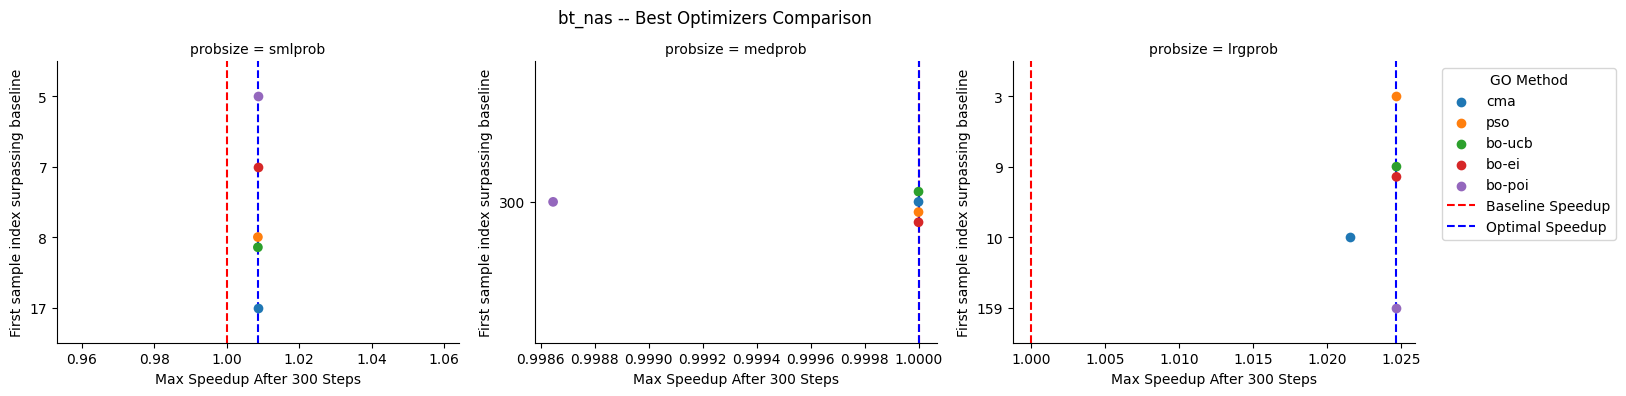

['hypers', 'method', 'probsize', 'progname']
wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-cma-avrgCummax.csv
bt_nas smlprob cma passed baseline on step 17.0
bt_nas smlprob cma reached optimal on step 17.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-pso-avrgCummax.csv
bt_nas smlprob pso passed baseline on step 8.0
bt_nas smlprob pso reached optimal on step 8.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-bo-ucb-avrgCummax.csv
bt_nas smlprob bo-ucb passed baseline on step 8.0
bt_nas smlprob bo-ucb reached optimal on step 8.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-bo-ei-avrgCummax.csv
bt_nas smlprob bo-ei passed baseline on step 7.0
bt_nas smlprob bo-ei reached optimal on step 7.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-bt_nas-smlprob-bo-poi-

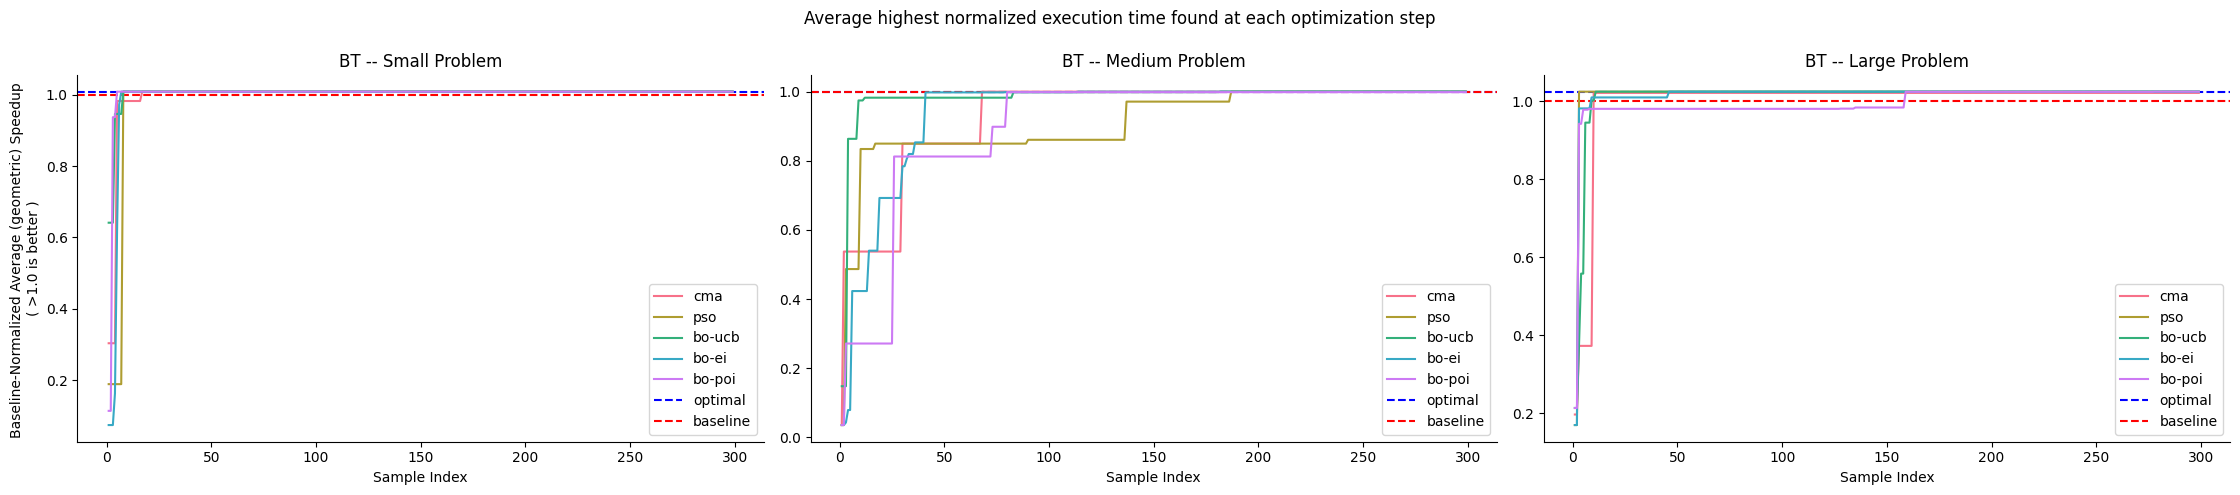

hpcg 

allBest
    firstSample  maxSpeedup     score probsize  method                                             hypers
0             1    1.083726  1.041863  smlprob     cma              (popsize=30.0, seed=4873, sigma=30.0)
1             1    1.199245  1.099622  medprob     cma              (popsize=30.0, seed=9999, sigma=30.0)
2             1    1.178025  1.089013  lrgprob     cma              (popsize=30.0, seed=9999, sigma=30.0)
3             1    1.083726  1.041863  smlprob     pso    (popsize=3.0, w=0.1, seed=1337, c1=0.1, c2=0.1)
4             1    1.199245  1.099622  medprob     pso  (popsize=12.0, w=0.55, seed=1337, c1=1.15, c2=...
5             1    1.178025  1.089013  lrgprob     pso  (popsize=15.0, w=0.775, seed=9999, c1=1.15, c2...
6             3    1.083726  0.708530  smlprob  bo-ucb                             (seed=3827, kappa=8.0)
7             1    1.199245  1.099622  medprob  bo-ucb                             (seed=9999, kappa=2.0)
8             1    1.178025  1.

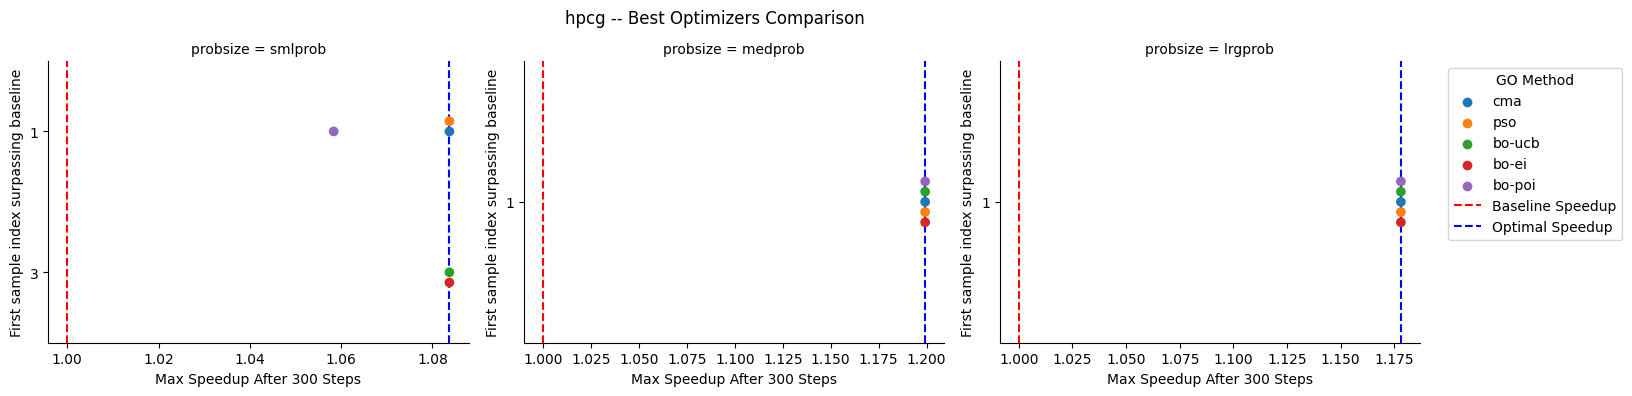

['hypers', 'method', 'probsize', 'progname']
wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-smlprob-cma-avrgCummax.csv
hpcg smlprob cma passed baseline on step 1.0
hpcg smlprob cma reached optimal on step 170.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-smlprob-pso-avrgCummax.csv
hpcg smlprob pso passed baseline on step 1.0
hpcg smlprob pso reached optimal on step 116.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-smlprob-bo-ucb-avrgCummax.csv
hpcg smlprob bo-ucb passed baseline on step 3.0
hpcg smlprob bo-ucb reached optimal on step 193.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-smlprob-bo-ei-avrgCummax.csv
hpcg smlprob bo-ei passed baseline on step 3.0
hpcg smlprob bo-ei reached optimal on step 239.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-hpcg-smlprob-bo-poi-avrgCummax.csv
hpcg 

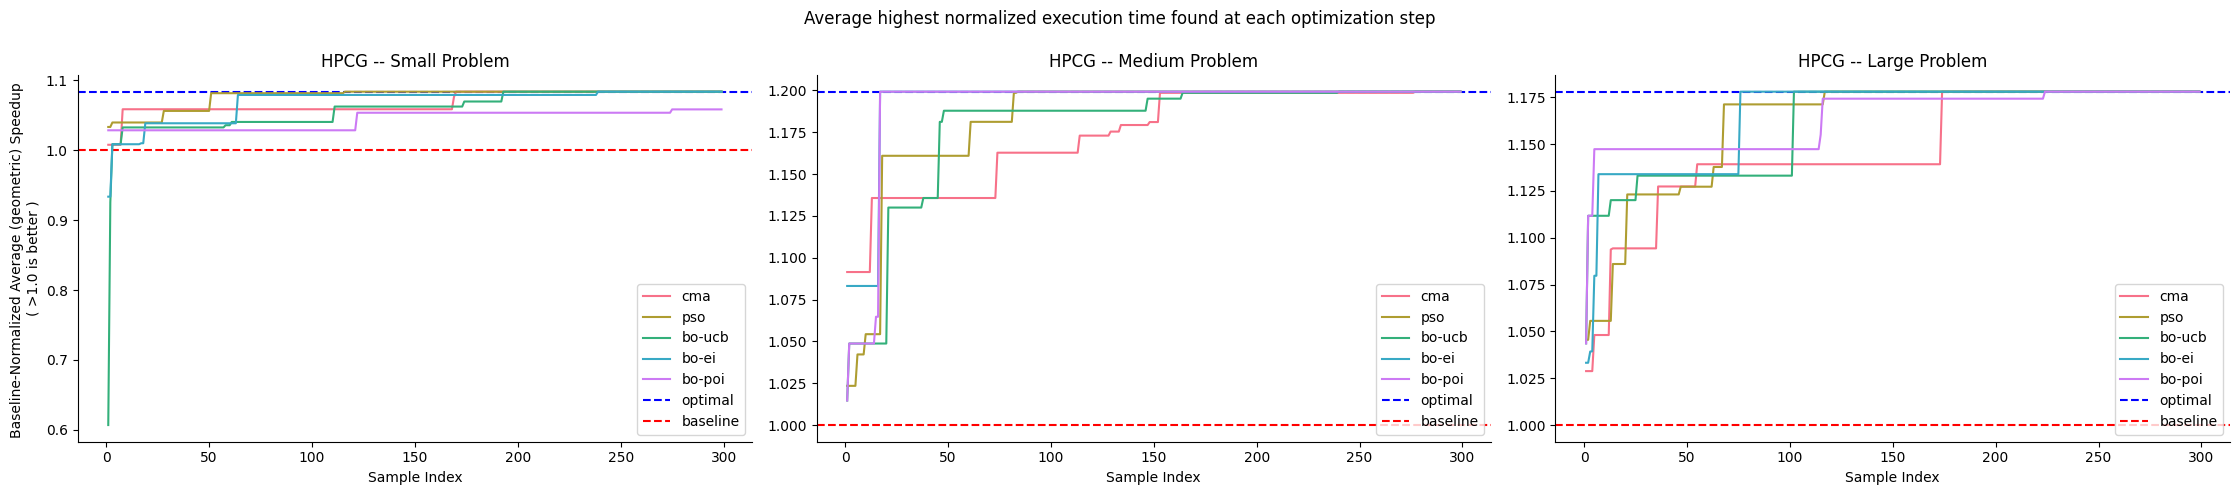

ft_nas 

allBest
    firstSample  maxSpeedup     score probsize  method                                             hypers
0            17    1.007092  0.532958  smlprob     cma              (popsize=6.0, seed=3827, sigma=7.444)
1            17    1.015371  0.537098  medprob     cma             (popsize=6.0, seed=3827, sigma=20.333)
2             3    1.131229  0.732281  lrgprob     cma               (popsize=3.0, seed=1337, sigma=30.0)
3             3    1.007092  0.670213  smlprob     pso    (popsize=3.0, w=0.1, seed=4873, c1=0.1, c2=0.8)
4             3    1.015371  0.674352  medprob     pso    (popsize=3.0, w=0.1, seed=4873, c1=0.1, c2=0.8)
5             3    1.155930  0.744631  lrgprob     pso  (popsize=3.0, w=0.325, seed=4873, c1=0.8, c2=0.1)
6            17    1.007092  0.532958  smlprob  bo-ucb                           (seed=3827, kappa=179.0)
7            16    1.012777  0.537638  medprob  bo-ucb                            (seed=4873, kappa=22.0)
8             4    1.155930  

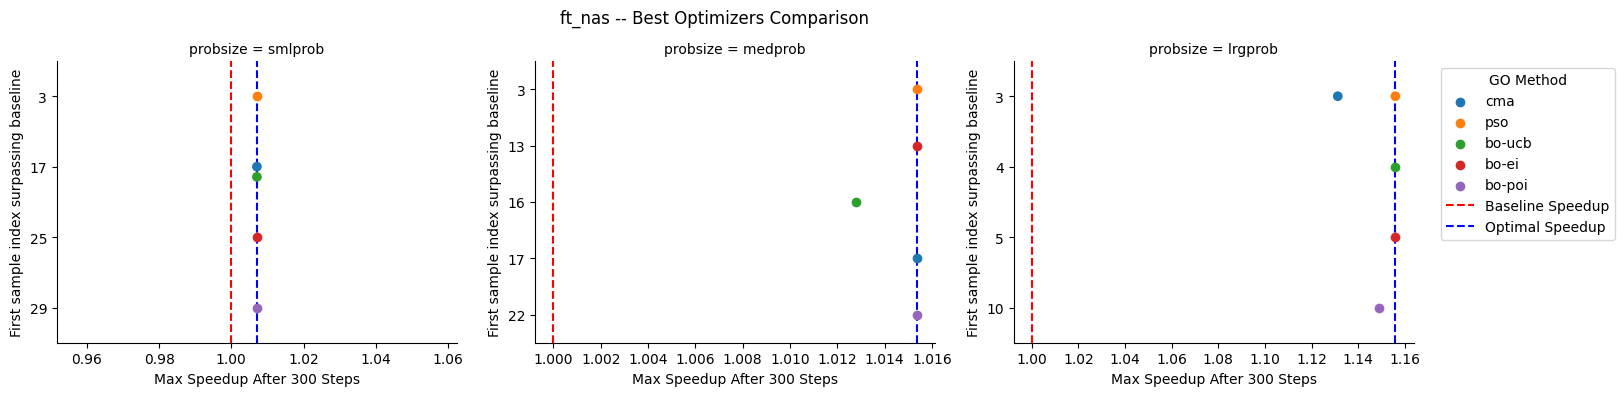

['hypers', 'method', 'probsize', 'progname']
wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-smlprob-cma-avrgCummax.csv
ft_nas smlprob cma passed baseline on step 17.0
ft_nas smlprob cma reached optimal on step 17.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-smlprob-pso-avrgCummax.csv
ft_nas smlprob pso passed baseline on step 3.0
ft_nas smlprob pso reached optimal on step 3.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-smlprob-bo-ucb-avrgCummax.csv
ft_nas smlprob bo-ucb passed baseline on step 17.0
ft_nas smlprob bo-ucb reached optimal on step 17.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-smlprob-bo-ei-avrgCummax.csv
ft_nas smlprob bo-ei passed baseline on step 25.0
ft_nas smlprob bo-ei reached optimal on step 25.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-ft_nas-smlprob-bo-

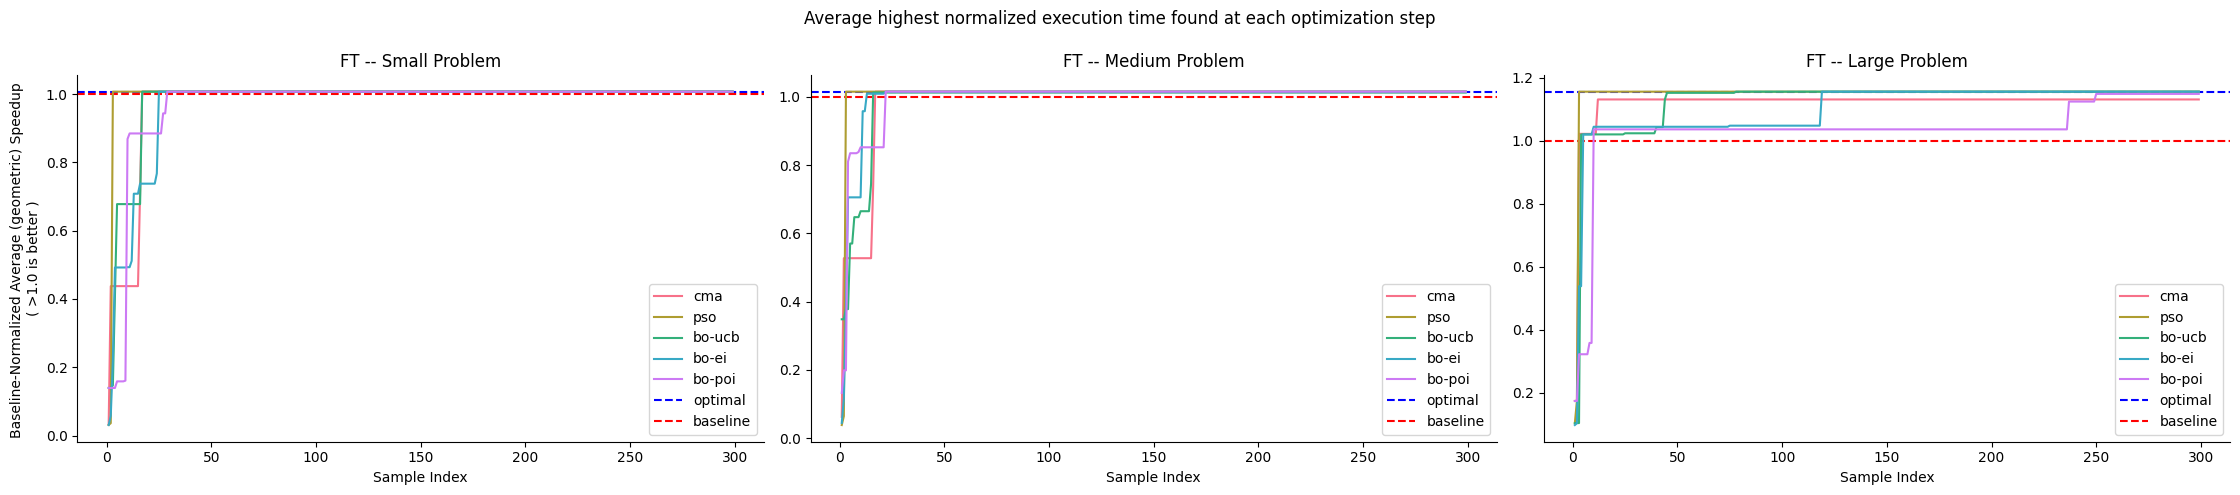

lulesh 

allBest
    firstSample  maxSpeedup     score probsize  method                                             hypers
0             1    4.383193  2.691597  smlprob     cma              (popsize=30.0, seed=9999, sigma=30.0)
1             1    2.493341  1.746670  medprob     cma               (popsize=6.0, seed=9999, sigma=30.0)
2             3    1.527679  0.930506  lrgprob     cma             (popsize=15.0, seed=3827, sigma=7.444)
3             1    4.383193  2.691597  smlprob     pso   (popsize=30.0, w=1.0, seed=9999, c1=1.5, c2=1.5)
4             1    2.493341  1.746670  medprob     pso  (popsize=27.0, w=0.55, seed=1337, c1=1.15, c2=...
5             3    1.527679  0.930506  lrgprob     pso  (popsize=3.0, w=0.775, seed=9999, c1=0.1, c2=1...
6             1    4.383193  2.691597  smlprob  bo-ucb                           (seed=4873, kappa=193.0)
7             1    2.493341  1.746670  medprob  bo-ucb                            (seed=9999, kappa=22.0)
8             2    1.527679  

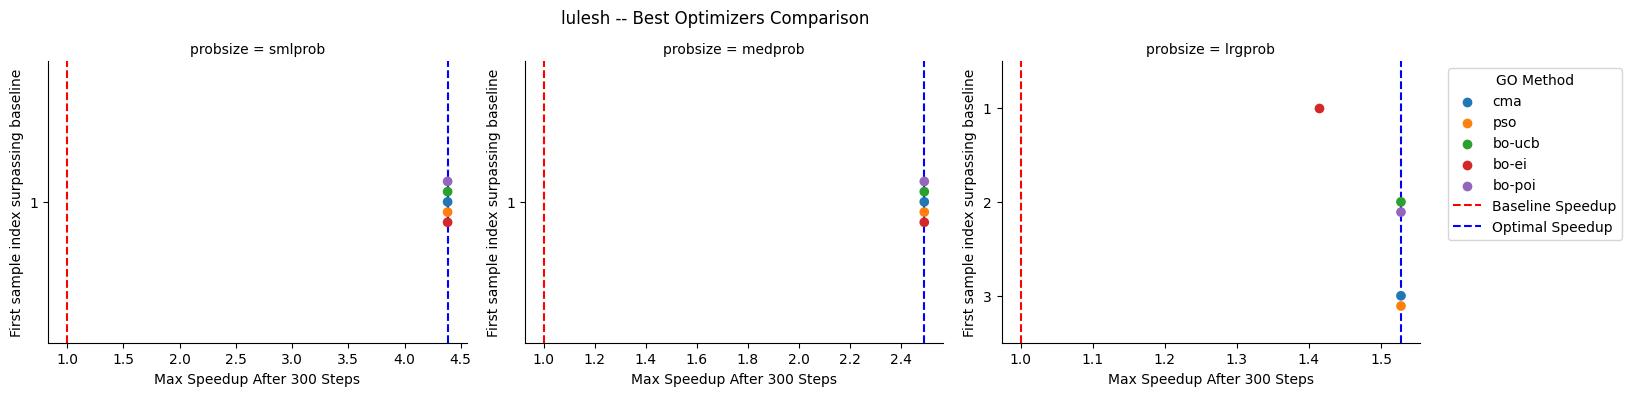

['hypers', 'method', 'probsize', 'progname']
wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-smlprob-cma-avrgCummax.csv
lulesh smlprob cma passed baseline on step 1.0
lulesh smlprob cma reached optimal on step 93.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-smlprob-pso-avrgCummax.csv
lulesh smlprob pso passed baseline on step 1.0
lulesh smlprob pso reached optimal on step 68.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-smlprob-bo-ucb-avrgCummax.csv
lulesh smlprob bo-ucb passed baseline on step 1.0
lulesh smlprob bo-ucb reached optimal on step 193.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-smlprob-bo-ei-avrgCummax.csv
lulesh smlprob bo-ei passed baseline on step 1.0
lulesh smlprob bo-ei reached optimal on step 18.0

wrote /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations/databases/ruby-lulesh-smlprob-bo-p

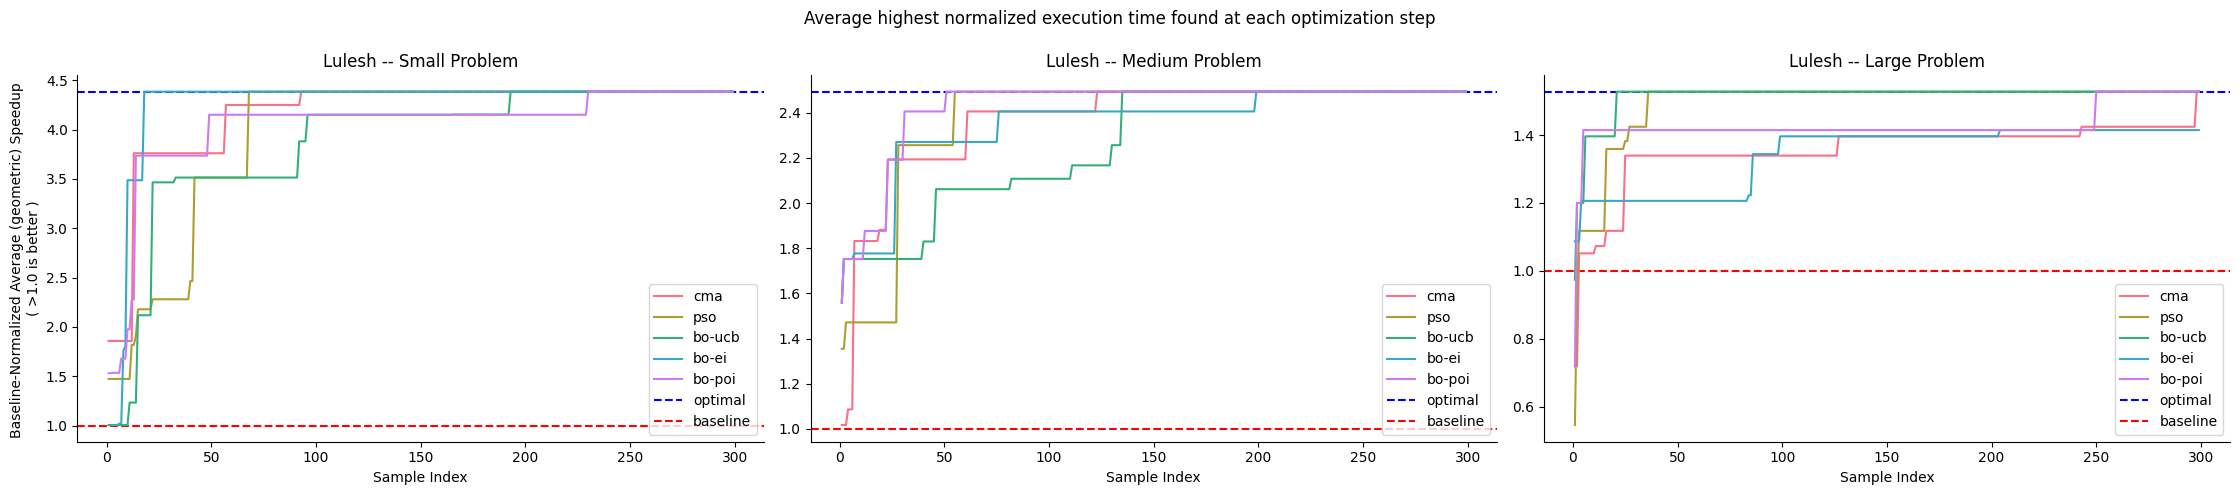

In [14]:
plotTopPoints(overallDF, 'bt_nas')
plotTopPoints(overallDF, 'hpcg')
plotTopPoints(overallDF, 'ft_nas')
plotTopPoints(overallDF, 'lulesh')